In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Add the directory where dynamics.py and utils.py are located to sys.path
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm import tqdm
from dynamics import SatelliteDynamics
from scipy.optimize import approx_fprime
from scipy.linalg import block_diag, solve
from utils import get_form_initial_conditions

In [4]:
# Simulation parameters
dt = 60.0  # Time step [s]
T = 395  # Duration [min]
T_RMSE = 300  # Index from which the RMSE is calculated
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 1
n_x = 6  # Number of states
n_p = 3  
n_y_1 = 3  # Number of measurements
n_y_2 = 2
n_y_3 = 2
n_y_4 = 2
K = T
W = 100 # Window size [min]

In [5]:
# Initial state vector and get the true state vectors (propagation) F
X_initial = get_form_initial_conditions(formation)
X_true = np.zeros((24, 1, T))
X_true[:, :, 0] = X_initial
for t in range(T - 1):
    X_true[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_true[:, :, t])

# Process noise
q_chief_pos = 1e-1  # [m]
q_chief_vel = 1e-2 # [m / s]
Q_chief = (
    np.diag(np.concatenate([q_chief_pos * np.ones(3), q_chief_vel * np.ones(3)]))
    ** 2
)
q_deputy_pos = 1e0  # [m]
q_deputy_vel = 1e-2  # [m / s]
Q_deputy = (
    np.diag(np.concatenate([q_deputy_pos * np.ones(3), q_deputy_vel * np.ones(3)]))
    ** 2
)
Q_deputies = block_diag(Q_deputy, Q_deputy, Q_deputy)
Q = block_diag(Q_chief, Q_deputies)

# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(6)])) ** 2
R = block_diag(R_chief, R_deputies)

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]])

In [6]:
def h_function_chief(x_vec):
    """
    Computes the measurement vector based on the current state vector.
    The measurement vector includes position components.

    Parameters:
    x_vec (np.array): The current state vector of the satellite (position [km] and velocity [km / s]).
    """
    return x_vec[0:3]

def h_function_deputy(x_vec):
    """
    Computes the measurement vector based on the current state vector.

    Parameters:
    x_vec (np.array): The current state vector of the satellite (position [km] and velocity [km / s]).

    Returns:
    y (np.array): The measurement vector of the satellite (range [km]).
    """
    r_chief = x_vec[:3]
    r_deputy1 = x_vec[6:9]
    r_deputy2 = x_vec[12:15]
    r_deputy3 = x_vec[18:21]

    range_deputy1_chief = np.linalg.norm(r_deputy1 - r_chief)
    range_deputy1_deputy2 = np.linalg.norm(r_deputy1 - r_deputy2)
    range_deputy1_deputy3 = np.linalg.norm(r_deputy1 - r_deputy3)
    range_deputy2_chief = np.linalg.norm(r_deputy2 - r_chief)
    range_deputy2_deputy3 = np.linalg.norm(r_deputy2 - r_deputy3)
    range_deputy3_chief = np.linalg.norm(r_deputy3 - r_chief)

    return np.array(
        [
            [range_deputy1_chief],
            [range_deputy1_deputy2],
            [range_deputy1_deputy3],
            [range_deputy2_chief],
            [range_deputy2_deputy3],
            [range_deputy3_chief],
        ]
    )

def h(x_vec):
    return np.concatenate([h_function_chief(x_vec), h_function_deputy(x_vec)])

In [7]:
# Simulation setup
np.random.seed(42)
X_est = np.zeros_like(X_true)
initial_dev = np.concatenate(
    (
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
    )
)
X_est[:, :, 0] = X_initial + initial_dev
for t in range(T - 1):
    X_est[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_est[:, :, t])

# Observations
Y = np.zeros((9, 1, T))
for t in range(T):
    Y[:, :, t] = h(X_true[:, :, t]) + np.random.normal(0, np.sqrt(np.diag(R)).reshape((9, 1)), size=(9, 1))
    
dev_chief_initial = np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).reshape(-1, 1)
dev_deputy1_initial = np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).reshape(-1, 1)
dev_deputy2_initial = np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).reshape(-1, 1)
dev_deputy3_initial = np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).reshape(-1, 1)

In [8]:
def surrogate_function(x_i, x_j, z_i, z_j, d_ij, sigma=None):
    """
    Compute the surrogate function Φ_ij.
    
    Args:
        x_i, x_j: Current position vectors for agents i and j
        z_i, z_j: Previous iteration position vectors (denoted as bar_x in the equation)
        d_ij: True measurement between agents i and j
        sigma: Standard deviation parameter
    """
    # Compute the norm of the difference between previous positions
    z_ij_norm = np.linalg.norm(P @ z_i - P @ z_j)
    
    # Term 1: ||x_i - bar_x_i||^2 / sigma^2
    term1 = np.linalg.norm(P @ x_i - P @ z_i)**2 / sigma**2
    
    # Term 2: (||bar_x_i - bar_x_j|| - d_ij) * (x_i - bar_x_i)^T(bar_x_i - bar_x_j) / (sigma^2 * ||bar_x_i - bar_x_j||)
    term2 = ((z_ij_norm - d_ij) / (sigma**2 * z_ij_norm)) * (P @ x_i - P @ z_i).T @ (P @ z_i - P @ z_j)
    
    # Term 3: ||x_j - bar_x_j||^2 / sigma^2
    term3 = np.linalg.norm(P @ x_j - P @ z_j)**2 / sigma**2
    
    # Term 4: -(||bar_x_i - bar_x_j|| - d_ij) * (x_j - bar_x_j)^T(bar_x_i - bar_x_j) / (sigma^2 * ||bar_x_i - bar_x_j||)
    term4 = -((z_ij_norm - d_ij) / (sigma**2 * z_ij_norm)) * (P @ x_j - P @ z_j).T @ (P @ z_i - P @ z_j)
    
    # Term 5: ||bar_x_i - bar_x_j||^2 / (2*sigma^2)
    term5 = z_ij_norm**2 / (2 * sigma**2)
    
    # Term 6: -d_ij * ||bar_x_i - bar_x_j|| / sigma^2
    term6 = -(d_ij * z_ij_norm) / sigma**2
    
    # Term 7: d_ij^2 / (2*sigma^2)
    term7 = d_ij**2 / (2 * sigma**2)
    
    return term1 + term2 + term3 + term4 + term5 + term6 + term7

def surrogate_gradient(x_i, x_j, z_i, z_j, d_ij, sigma=None):
    """
    Compute the gradient of the surrogate function Φ_ij.
    """
    z_ij_norm = np.linalg.norm(P @ z_i - P @ z_j)
    z_ij = P @ z_i - P @ z_j
    
    # Gradient with respect to x_i
    grad_i = (2/sigma**2) * P.T @ (P @ x_i - P @ z_i) + ((z_ij_norm - d_ij) / (sigma**2 * z_ij_norm)) * P.T @ z_ij
    
    # Gradient with respect to x_j
    grad_j = (2/sigma**2) * P.T @ (P @ x_j - P @ z_j) - ((z_ij_norm - d_ij) / (sigma**2 * z_ij_norm)) * P.T @ z_ij
    
    return grad_i, grad_j

def surrogate_hessian(x_i, x_j, z_i, z_j, d_ij, sigma=None):
    """
    Compute the Hessian of the surrogate function Φ_ij.
    """
    n = len(x_i)
    
    # The Hessian is constant with respect to x_i and x_j
    H_ii = (2/sigma**2) * P.T @ P
    H_ij = P.T @ np.zeros((n, n)) @ P
    H_ji = P.T @ np.zeros((n, n)) @ P
    H_jj = (2/sigma**2) * P.T @ P
    
    return H_ii, H_ij, H_ji, H_jj

In [9]:
def f(x_0, y, z_0=None):
    """
    Cost function combining direct measurements and surrogate terms.
    """
    f_x_0 = 0
    if z_0 is None:
        z_0 = x_0.copy()

    # Extract positions for each satellite
    x_1_k = x_0[:n_x, :]
    x_2_k = x_0[n_x:2*n_x, :]
    x_3_k = x_0[2*n_x:3*n_x, :]
    x_4_k = x_0[3*n_x:4*n_x, :]
    
    z_1_k = z_0[:n_x, :]
    z_2_k = z_0[n_x:2*n_x, :]
    z_3_k = z_0[2*n_x:3*n_x, :]
    z_4_k = z_0[3*n_x:4*n_x, :]
    
    for k in range(W):    
        # 1. Direct measurements (deputies to chief)
        y_1_k = y[:n_y_1, :, k]
        y_rel_k = y[n_y_1:, :, k]

        # Chief absolute measurements
        residual = y_1_k - P @ x_1_k
        f_x_0 += 1/2 * residual.T @ np.linalg.inv(R_chief) @ residual

        # Deputy-to-chief measurements
        y_21_k = y_rel_k[0]  # Deputy 1 to chief
        y_31_k = y_rel_k[3]  # Deputy 2 to chief
        y_41_k = y_rel_k[5]  # Deputy 3 to chief

        # Process direct measurements (deputies to chief)
        pairs_direct = [
            (2, 1, x_2_k, x_1_k, y_21_k),
            (3, 1, x_3_k, x_1_k, y_31_k),
            (4, 1, x_4_k, x_1_k, y_41_k),
        ]

        for i, j, x_i_k, x_j_k, y_ij_k in pairs_direct:
            d_ij_k_vec = P @ x_i_k - P @ x_j_k
            d_ij_k = np.linalg.norm(d_ij_k_vec)
            f_x_0 += (y_ij_k - d_ij_k) ** 2 / (2 * r_deputy_pos**2)

        # 2. Surrogate terms for residual edges (between deputies)
        pairs_surrogate = [
            (x_2_k, x_3_k, z_2_k, z_3_k, y_rel_k[1]),  # Deputies 1-2
            (x_2_k, x_4_k, z_2_k, z_4_k, y_rel_k[2]),  # Deputies 1-3
            (x_3_k, x_4_k, z_3_k, z_4_k, y_rel_k[4]),  # Deputies 2-3
        ]

        for x_i_k, x_j_k, z_i_k, z_j_k, d_ij_k in pairs_surrogate:
            f_x_0 += surrogate_function(x_i_k, x_j_k, z_i_k, z_j_k, d_ij_k, sigma=r_deputy_pos)

        if k < W - 1:
            # Propagate states
            x_1_k = SatelliteDynamics().x_new(dt, x_1_k)
            x_2_k = SatelliteDynamics().x_new(dt, x_2_k)
            x_3_k = SatelliteDynamics().x_new(dt, x_3_k)
            x_4_k = SatelliteDynamics().x_new(dt, x_4_k)
            
            z_1_k = SatelliteDynamics().x_new(dt, z_1_k)
            z_2_k = SatelliteDynamics().x_new(dt, z_2_k)
            z_3_k = SatelliteDynamics().x_new(dt, z_3_k)
            z_4_k = SatelliteDynamics().x_new(dt, z_4_k)

    return f_x_0

def grad_f(x_0, y, z_0=None):
    """
    Gradient of cost function.
    """
    grad_f_x_0 = np.zeros_like(x_0)
    if z_0 is None:
        z_0 = x_0.copy()

    # Extract positions and STMs
    x_1_k = x_0[:n_x, :]
    x_2_k = x_0[n_x:2*n_x, :]
    x_3_k = x_0[2*n_x:3*n_x, :]
    x_4_k = x_0[3*n_x:4*n_x, :]
    
    z_1_k = z_0[:n_x, :]
    z_2_k = z_0[n_x:2*n_x, :]
    z_3_k = z_0[2*n_x:3*n_x, :]
    z_4_k = z_0[3*n_x:4*n_x, :]
    
    F_1_k = np.eye(n_x)
    F_2_k = np.eye(n_x)
    F_3_k = np.eye(n_x)
    F_4_k = np.eye(n_x)

    for k in range(W):
        # 1. Direct measurements (deputies to chief)
        y_1_k = y[:n_y_1, :, k]
        y_rel_k = y[n_y_1:, :, k]

        # Chief absolute measurements gradient
        grad_f_x_0[:n_x, :] -= F_1_k.T @ P.T @ np.linalg.inv(R_chief) @ (y_1_k - P @ x_1_k)

        # Process direct measurements gradients (deputies to chief)
        pairs_direct = [
            (2, 1, x_2_k, x_1_k, y_rel_k[0], F_2_k, F_1_k),
            (3, 1, x_3_k, x_1_k, y_rel_k[3], F_3_k, F_1_k),
            (4, 1, x_4_k, x_1_k, y_rel_k[5], F_4_k, F_1_k),
        ]

        for i, j, x_i_k, x_j_k, y_ij_k, STM_t0_i, STM_t0_j in pairs_direct:
            d_ij_k_vec = P @ x_i_k - P @ x_j_k
            d_ij_k = np.linalg.norm(d_ij_k_vec)
            
            grad_i = -(y_ij_k - d_ij_k) / r_deputy_pos**2 * (STM_t0_i.T @ P.T @ d_ij_k_vec) / d_ij_k
            grad_j = (y_ij_k - d_ij_k) / r_deputy_pos**2 * (STM_t0_j.T @ P.T @ d_ij_k_vec) / d_ij_k
            
            grad_f_x_0[(i-1)*n_x:i*n_x, :] += grad_i
            grad_f_x_0[(j-1)*n_x:j*n_x, :] += grad_j

        # 2. Surrogate terms gradients (between deputies)
        pairs_surrogate = [
            (2, 3, x_2_k, x_3_k, z_2_k, z_3_k, y_rel_k[1], F_2_k, F_3_k),  # Deputies 1-2
            (2, 4, x_2_k, x_4_k, z_2_k, z_4_k, y_rel_k[2], F_2_k, F_4_k),  # Deputies 1-3
            (3, 4, x_3_k, x_4_k, z_3_k, z_4_k, y_rel_k[4], F_3_k, F_4_k),  # Deputies 2-3
        ]

        for i, j, x_i_k, x_j_k, z_i_k, z_j_k, d_ij_k, STM_t0_i, STM_t0_j in pairs_surrogate:
            grad_i, grad_j = surrogate_gradient(x_i_k, x_j_k, z_i_k, z_j_k, d_ij_k, sigma=r_deputy_pos)
            
            grad_f_x_0[(i-1)*n_x:i*n_x, :] += STM_t0_i.T @ grad_i
            grad_f_x_0[(j-1)*n_x:j*n_x, :] += STM_t0_j.T @ grad_j

        if k < W - 1:
            # Propagate states and STMs
            F_1_old = F_1_k
            F_2_old = F_2_k
            F_3_old = F_3_k
            F_4_old = F_4_k
            
            x_1_k, F_1_k = SatelliteDynamics().x_new_and_F(dt, x_1_k)
            x_2_k, F_2_k = SatelliteDynamics().x_new_and_F(dt, x_2_k)
            x_3_k, F_3_k = SatelliteDynamics().x_new_and_F(dt, x_3_k)
            x_4_k, F_4_k = SatelliteDynamics().x_new_and_F(dt, x_4_k)
            
            F_1_k = F_1_k @ F_1_old
            F_2_k = F_2_k @ F_2_old
            F_3_k = F_3_k @ F_3_old
            F_4_k = F_4_k @ F_4_old
            
            z_1_k = SatelliteDynamics().x_new(dt, z_1_k)
            z_2_k = SatelliteDynamics().x_new(dt, z_2_k)
            z_3_k = SatelliteDynamics().x_new(dt, z_3_k)
            z_4_k = SatelliteDynamics().x_new(dt, z_4_k)

    return grad_f_x_0

def hessian_f(x_0, y, z_0=None):
    """
    Hessian of cost function combining direct measurements and surrogate terms.
    """
    hessian_f_x_0 = np.zeros((x_0.shape[0], x_0.shape[0]))
    if z_0 is None:
        z_0 = x_0.copy()

    # Extract positions and STMs
    x_1_k = x_0[:n_x, :]
    x_2_k = x_0[n_x:2*n_x, :]
    x_3_k = x_0[2*n_x:3*n_x, :]
    x_4_k = x_0[3*n_x:4*n_x, :]
    
    z_1_k = z_0[:n_x, :]
    z_2_k = z_0[n_x:2*n_x, :]
    z_3_k = z_0[2*n_x:3*n_x, :]
    z_4_k = z_0[3*n_x:4*n_x, :]
    
    F_1_k = np.eye(n_x)
    F_2_k = np.eye(n_x)
    F_3_k = np.eye(n_x)
    F_4_k = np.eye(n_x)

    for k in range(W):
        # 1. Direct measurements (deputies to chief)
        y_1_k = y[:n_y_1, :, k]
        y_rel_k = y[n_y_1:, :, k]

        # Chief absolute measurements Hessian
        hessian_f_x_0[:n_x, :n_x] += F_1_k.T @ P.T @ np.linalg.inv(R_chief) @ P @ F_1_k

        # Process direct measurements Hessian (deputies to chief)
        pairs_direct = [
            (2, 1, x_2_k, x_1_k, y_rel_k[0], F_2_k, F_1_k),
            (3, 1, x_3_k, x_1_k, y_rel_k[3], F_3_k, F_1_k),
            (4, 1, x_4_k, x_1_k, y_rel_k[5], F_4_k, F_1_k),
        ]

        for i, j, x_i_k, x_j_k, y_ij_k, STM_t0_i, STM_t0_j in pairs_direct:
            d_ij_k_vec = P @ x_i_k - P @ x_j_k
            d_ij_k = np.linalg.norm(d_ij_k_vec)
            
            # Compute Hessian blocks for direct measurements
            H_term = 1/r_deputy_pos**2 * (
                ((y_ij_k - d_ij_k)/d_ij_k) * P.T @ P -
                (y_ij_k/d_ij_k**3) * P.T @ (d_ij_k_vec @ d_ij_k_vec.T) @ P
            )
            
            idx_i = (i-1)*n_x
            idx_j = (j-1)*n_x
            
            # Update Hessian blocks
            hessian_f_x_0[idx_i:idx_i+n_x, idx_i:idx_i+n_x] -= STM_t0_i.T @ H_term @ STM_t0_i
            hessian_f_x_0[idx_i:idx_i+n_x, idx_j:idx_j+n_x] += STM_t0_i.T @ H_term @ STM_t0_j
            hessian_f_x_0[idx_j:idx_j+n_x, idx_i:idx_i+n_x] += STM_t0_j.T @ H_term @ STM_t0_i
            hessian_f_x_0[idx_j:idx_j+n_x, idx_j:idx_j+n_x] -= STM_t0_j.T @ H_term @ STM_t0_j

        # 2. Surrogate terms Hessian (between deputies)
        pairs_surrogate = [
            (2, 3, P @ x_2_k, P @ x_3_k, P @ z_2_k, P @ z_3_k, y_rel_k[1], F_2_k, F_3_k),  # Deputies 1-2
            (2, 4, P @ x_2_k, P @ x_4_k, P @ z_2_k, P @ z_4_k, y_rel_k[2], F_2_k, F_4_k),  # Deputies 1-3
            (3, 4, P @ x_3_k, P @ x_4_k, P @ z_3_k, P @ z_4_k, y_rel_k[4], F_3_k, F_4_k),  # Deputies 2-3
        ]

        for i, j, x_i_k, x_j_k, z_i_k, z_j_k, d_ij_k, STM_t0_i, STM_t0_j in pairs_surrogate:
            H_ii, H_ij, H_ji, H_jj = surrogate_hessian(x_i_k, x_j_k, z_i_k, z_j_k, d_ij_k, sigma=r_deputy_pos)
            
            idx_i = (i-1)*n_x
            idx_j = (j-1)*n_x
            
            # Update Hessian blocks with surrogate terms
            hessian_f_x_0[idx_i:idx_i+n_x, idx_i:idx_i+n_x] += STM_t0_i.T @ H_ii @ STM_t0_i
            hessian_f_x_0[idx_i:idx_i+n_x, idx_j:idx_j+n_x] += STM_t0_i.T @ H_ij @ STM_t0_j
            hessian_f_x_0[idx_j:idx_j+n_x, idx_i:idx_i+n_x] += STM_t0_j.T @ H_ji @ STM_t0_i
            hessian_f_x_0[idx_j:idx_j+n_x, idx_j:idx_j+n_x] += STM_t0_j.T @ H_jj @ STM_t0_j

        if k < W - 1:
            # Propagate states and STMs
            F_1_old = F_1_k
            F_2_old = F_2_k
            F_3_old = F_3_k
            F_4_old = F_4_k
            
            x_1_k, F_1_k = SatelliteDynamics().x_new_and_F(dt, x_1_k)
            x_2_k, F_2_k = SatelliteDynamics().x_new_and_F(dt, x_2_k)
            x_3_k, F_3_k = SatelliteDynamics().x_new_and_F(dt, x_3_k)
            x_4_k, F_4_k = SatelliteDynamics().x_new_and_F(dt, x_4_k)
            
            F_1_k = F_1_k @ F_1_old
            F_2_k = F_2_k @ F_2_old
            F_3_k = F_3_k @ F_3_old
            F_4_k = F_4_k @ F_4_old
            
            z_1_k = SatelliteDynamics().x_new(dt, z_1_k)
            z_2_k = SatelliteDynamics().x_new(dt, z_2_k)
            z_3_k = SatelliteDynamics().x_new(dt, z_3_k)
            z_4_k = SatelliteDynamics().x_new(dt, z_4_k)

    return hessian_f_x_0

# def numerical_gradient(f, x_0, y, z_0=None, epsilon=1e-6):
#     """
#     Compute the numerical gradient of f at x_0 using finite differences.
    
#     Args:
#         f (function): The cost function.
#         x_0 (numpy.ndarray): The current state vector.
#         STM (numpy.ndarray): State transition matrix.
#         y (numpy.ndarray): Observed data.
#         epsilon (float): Small perturbation for finite differences.

#     Returns:
#         numpy.ndarray: Numerical gradient of f at x_0.
#     """
#     if z_0 is None:
#         z_0 = x_0.copy()
    
#     grad = np.zeros_like(x_0)
#     for i in range(x_0.size):
#         # Create perturbed versions of x_0
#         x_0_plus = x_0.copy()
#         x_0_minus = x_0.copy()
        
#         # Add and subtract epsilon to the i-th component
#         x_0_plus[i] += epsilon
#         x_0_minus[i] -= epsilon
        
#         # Compute the function value for perturbed inputs
#         f_plus = f(x_0_plus, y, z_0)
#         f_minus = f(x_0_minus, y, z_0)
        
#         # Central difference approximation
#         grad[i] = (f_plus - f_minus) / (2 * epsilon)
    
#     return grad

# Test grad_f using scipy's approx_fprime
# n = 0
# m = 0
# W = 100
# numerical_grad = numerical_gradient(f, X_true[:, :, n], Y[:, :, n:n + W], X_true[:, :, m]).flatten()
# analytical_grad = grad_f(X_true[:, :, n], Y[:, :, n:n + W], X_true[:, :, m]).flatten()
# print("Numerical Gradient:", numerical_grad)
# print("Analytical Gradient:", analytical_grad)
# print("Gradient Difference:", numerical_grad - analytical_grad)
# -np.linalg.inv(hessian_f(X_true[:, :, n], Y[:, :, n:n + W], X_true[:, :, m])) @ grad_f(X_true[:, :, n], Y[:, :, n:n + W], X_true[:, :, m])

# def numerical_hessian(f, x_0, y, z_0=None, epsilon=1e-6):
#     """
#     Compute the numerical Hessian of f at x_0 using finite differences.
    
#     Args:
#         f (function): The cost function.
#         x_0 (numpy.ndarray): The current state vector.
#         y (numpy.ndarray): Observed data.
#         z_0 (numpy.ndarray, optional): Previous iteration state vector.
#         epsilon (float): Small perturbation for finite differences.

#     Returns:
#         numpy.ndarray: Numerical Hessian of f at x_0.
#     """
#     if z_0 is None:
#         z_0 = x_0.copy()
    
#     n = x_0.size
#     H = np.zeros((n, n))
    
#     for i in range(n):
#         for j in range(n):
#             # Create perturbed versions of x_0
#             x_pp = x_0.copy()  # x plus-plus
#             x_pm = x_0.copy()  # x plus-minus
#             x_mp = x_0.copy()  # x minus-plus
#             x_mm = x_0.copy()  # x minus-minus
            
#             # Add/subtract epsilon to the i,j components
#             x_pp[i] += epsilon
#             x_pp[j] += epsilon
            
#             x_pm[i] += epsilon
#             x_pm[j] -= epsilon
            
#             x_mp[i] -= epsilon
#             x_mp[j] += epsilon
            
#             x_mm[i] -= epsilon
#             x_mm[j] -= epsilon
            
#             # Compute function values and ensure they're scalar
#             f_pp = f(x_pp, y, z_0).item()
#             f_pm = f(x_pm, y, z_0).item()
#             f_mp = f(x_mp, y, z_0).item()
#             f_mm = f(x_mm, y, z_0).item()
            
#             # Central difference approximation for second derivative
#             H[i, j] = (f_pp - f_pm - f_mp + f_mm) / (4 * epsilon * epsilon)
    
#     return H

# # Example usage to test:
# n = 0  # time index
# m = 0  # previous iteration time index
# W = 1  # window size

# numerical_H = numerical_hessian(f, X_true[:, :, n], Y[:, :, n:n + W], X_true[:, :, m])
# analytical_H = hessian_f(X_true[:, :, n], Y[:, :, n:n + W], X_true[:, :, m])

# print("Numerical Hessian:", numerical_H)
# print("Analytical Hessian:", analytical_H)
# print("Hessian Difference:", np.linalg.norm(numerical_H - analytical_H))

# Test grad_f using scipy's approx_fprime
# n = 0
# m = 10
# W = 10
# Y = np.zeros((9, 1, T))
# for t in range(T):
#     Y[:, :, t] = h(X_true[:, :, t]) + np.random.normal(0, np.sqrt(np.diag(R)).reshape((9, 1)), size=(9, 1))
# x_init = np.zeros((4 * n_x, 1))
# x_init[:4*n_x, :] = X_est[:, :, 0]
# f(x_init, Y[:, :, n:n + W]), f(x_init, Y[:, :, n:n + W], X_true[:, :, m]), np.linalg.norm(grad_f(x_init, Y[:, :, n:n + W])), np.linalg.norm(grad_f(x_init, Y[:, :, n:n + W], X_true[:, :, m]))

In [10]:
def L(x_0, y, z_0=None):
    """
    Lagrangian wrapper for the cost function.
    """
    return f(x_0, y, z_0)
    
def grad_L(x_0, y, z_0=None):
    """
    Gradient of Lagrangian wrapper.
    """
    return grad_f(x_0, y, z_0)

def hessian_L(x_0, y, z_0=None):
    """
    Hessian of Lagrangian wrapper.
    """
    return hessian_f(x_0, y, z_0)

In [11]:

class MM_Newton:
    def __init__(self, grad_tol=1e0, max_iter=20, mm_tol=1e0, mm_max_iter=5):
        self.grad_tol = grad_tol
        self.max_iter = max_iter
        self.mm_tol = mm_tol
        self.mm_max_iter = mm_max_iter
        
        # Storage for results
        self.cost_function_values = []
        self.grad_norm_values = []

    def solve(self, x_init, Y, X_true):
        x = x_init
        z = x_init.copy()  # Initialize z as current iterate
        
        for mm_iter in range(self.mm_max_iter):
            print(f"\nMajorization-Minimization Iteration {mm_iter + 1}")
            
            prev_cost_function_value = None
            prev_grad_norm_value = None
            prev_global_error = None
            
            # Solve the surrogate problem
            for iteration in range(self.max_iter):
                # Compute the cost function, gradient and Hessian using current z
                L_x = L(x, Y, z)
                grad_L_x = grad_L(x, Y, z)
                hessian_L_x = hessian_L(x, Y, z)

                # Convergence tracking
                cost_function_value = L_x[0][0]
                grad_norm_value = np.linalg.norm(grad_L_x)

                # Store the norms
                self.cost_function_values.append(cost_function_value)
                self.grad_norm_values.append(grad_norm_value)
                
                if prev_cost_function_value is not None:
                    cost_function_change = (cost_function_value - prev_cost_function_value) / abs(prev_cost_function_value) * 100
                    grad_norm_change = (grad_norm_value - prev_grad_norm_value) / abs(prev_grad_norm_value) * 100
                    global_error_change = (np.linalg.norm(x - X_true) - prev_global_error) / abs(prev_global_error) * 100
                prev_cost_function_value = cost_function_value
                prev_grad_norm_value = grad_norm_value
                prev_global_error = np.linalg.norm(x - X_true)

                # Check convergence and print metrics
                if grad_norm_value < self.grad_tol or iteration + 1 == self.max_iter:
                    print(f"STOP on Iteration {iteration}\nCost function = {cost_function_value} ({cost_function_change:.2f}%)\nGradient norm = {grad_norm_value} ({grad_norm_change:.2f}%)\nGlobal relative error = {np.linalg.norm(x - X_true)} ({global_error_change:.2f}%)")
                    print(f"Final position relative errors: {np.linalg.norm(x[0:3, :] - X_true[0:3, :])} m, {np.linalg.norm(x[6:9, :] - X_true[6:9, :])} m, {np.linalg.norm(x[12:15, :] - X_true[12:15, :])} m, {np.linalg.norm(x[18:21, :] - X_true[18:21, :])} m\n")
                    break
                else:
                    if iteration == 0:
                        print(f"Before applying the algorithm\nCost function: {cost_function_value}\nGradient norm: {grad_norm_value}\nGlobal relative error: {np.linalg.norm(x - X_true)}")
                    else:
                        print(f"Iteration {iteration}\nCost function: {cost_function_value} ({cost_function_change:.2f}%)\nGradient norm: {grad_norm_value} ({grad_norm_change:.2f}%)\nGlobal relative error = {np.linalg.norm(x - X_true)} ({global_error_change:.2f}%)")
                        
                # Print relative errors 
                print(f"Position relative errors: {np.linalg.norm(x[0:3, :] - X_true[0:3, :])} m, {np.linalg.norm(x[6:9, :] - X_true[6:9, :])} m, {np.linalg.norm(x[12:15, :] - X_true[12:15, :])} m, {np.linalg.norm(x[18:21, :] - X_true[18:21, :])} m\n")
                
                # Solve for the Newton step
                delta_x = solve(hessian_L_x, -grad_L_x)
                x += delta_x
            
            # Update z for next majorization step
            if np.linalg.norm(x - z) < self.mm_tol:
                print(f"Majorization-Minimization converged after {mm_iter + 1} iterations")
                break
            
            # Update z for next majorization step
            z = x.copy()

        return x

In [12]:
def give_me_the_plots(cost_function_values, grad_norm_values):
    iterations = np.arange(0, len(cost_function_values))

    # Plot 1
    plt.semilogy(iterations, cost_function_values, '.-')
    plt.xlabel(r'$m$')
    plt.ylabel(r'$L(x^{(m)})$')
    plt.grid(True)
    plt.grid(True, which="minor", linestyle='--')
    plt.show()
    
    # Plot 2
    plt.semilogy(iterations, grad_norm_values, '.-')
    plt.xlabel(r'$m$')
    plt.ylabel(r'$||\nabla L(x^{(m)})||_2$')
    plt.grid(True)
    plt.grid(True, which="minor", linestyle='--')
    plt.show()

Windows:   0%|          | 0/2 [00:00<?, ?it/s]


Majorization-Minimization Iteration 1
Before applying the algorithm
Cost function: 2766689615.997539
Gradient norm: 75894478733.16005
Global relative error: 395.60563949432424
Position relative errors: 82.78540989608044 m, 181.7491507333766 m, 258.73787052498585 m, 222.8729633755392 m

Iteration 1
Cost function: 316984916.8562401 (-88.54%)
Gradient norm: 33232234.046516437 (-99.96%)
Global relative error = 385.35117926600657 (-2.59%)
Position relative errors: 2.2534757067830755 m, 182.71039763428368 m, 236.67162579106449 m, 243.091822991222 m

Iteration 2
Cost function: 316977226.8294569 (-0.00%)
Gradient norm: 1852.0336313923042 (-99.99%)
Global relative error = 386.6483702812793 (0.34%)
Position relative errors: 2.2061350058550686 m, 183.50129661777308 m, 237.32742659957796 m, 243.91553460566445 m

STOP on Iteration 3
Cost function = 316977226.82936084 (-0.00%)
Gradient norm = 0.2812280727032751 (-99.98%)
Global relative error = 386.6484009992893 (0.00%)
Final position relative erro

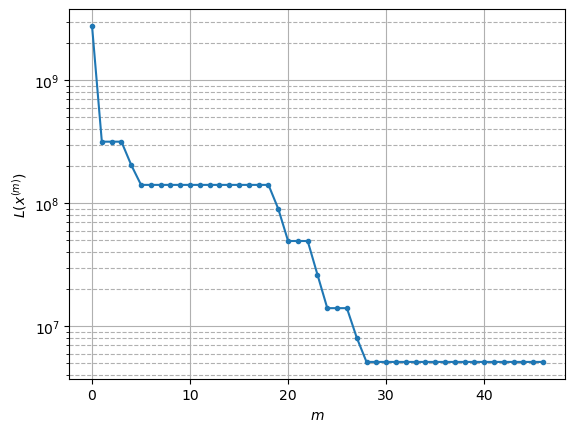

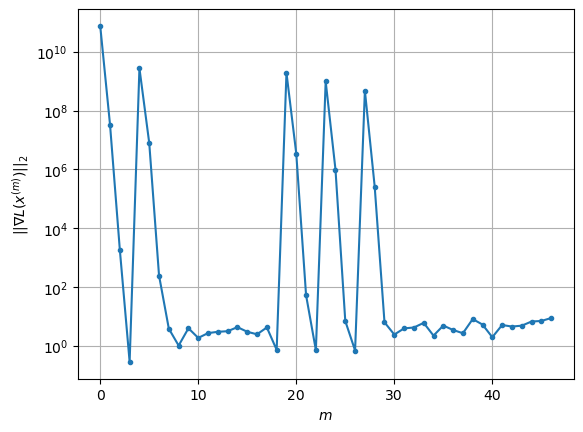

Windows:  50%|█████     | 1/2 [02:18<02:18, 138.48s/it]


Majorization-Minimization Iteration 1
Before applying the algorithm
Cost function: 3720577.7870971854
Gradient norm: 271632788.93375933
Global relative error: 223.01619940569753
Position relative errors: 0.42079181832877754 m, 25.44088897683071 m, 207.95353817149697 m, 76.44572968238934 m

Iteration 1
Cost function: 2756673.5391863366 (-25.91%)
Gradient norm: 85749.00159427087 (-99.97%)
Global relative error = 217.89501546250108 (-2.30%)
Position relative errors: 0.2989529372021538 m, 29.83827171768413 m, 206.41496230773393 m, 63.09138171776889 m

STOP on Iteration 2
Cost function = 2756673.4431264666 (-0.00%)
Gradient norm = 0.4141435739158677 (-100.00%)
Global relative error = 217.8978556284782 (0.00%)
Final position relative errors: 0.2995905709907635 m, 29.837123383100202 m, 206.4164735085298 m, 63.09678635888732 m


Majorization-Minimization Iteration 2
Before applying the algorithm
Cost function: 2167816.994740088
Gradient norm: 177484992.37884656
Global relative error: 217.8978

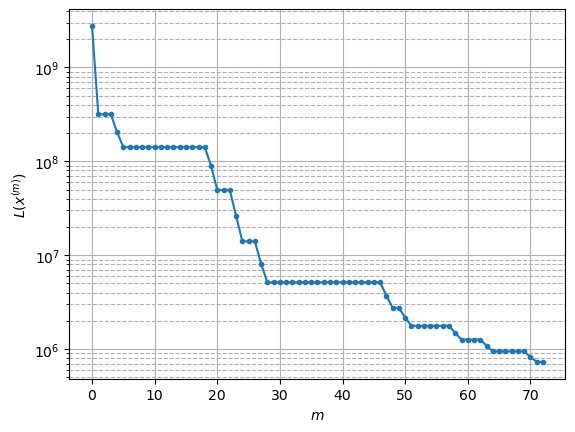

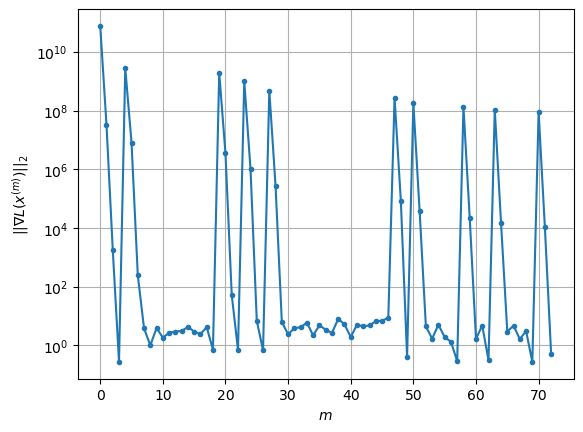

RMSE after convergence:
Chief: 0.31 m
Deputy 1: 42.87 m
Deputy 2: 206.06 m
Deputy 3: 91.63 m


In [13]:
# Main execution loop
def run_estimation():
    
    Y = np.zeros((9, 1, T))
    for t in range(T):
        Y[:, :, t] = h(X_true[:, :, t]) + np.random.normal(0, np.sqrt(np.diag(R)).reshape((9, 1)), size=(9, 1))
        
    # Initialize storage for results
    X_est_mm = np.zeros_like(X_true)
    X_est_mm[:, :, 0] = X_est[:, :, 0]  # Use same initial conditions
    
    # Storage for errors
    errors_chief_mm = []
    errors_deputy1_mm = []
    errors_deputy2_mm = []
    errors_deputy3_mm = []
    
    # Initialize solver
    solver = MM_Newton()
    
    # Sliding window estimation
    for t in tqdm(range(T - W + 1), desc="Windows", leave=False):
        # Get measurements for current window
        Y_window = Y[:, :, t:t + W]
        
        # Initial guess is the previous estimate propagated forward
        if t == 0:
            x_init = X_est[:, :, t]
        else:
            x_init = X_est_mm[:, :, t]
        
        # Solve the optimization problem
        x_sol = solver.solve(x_init, Y_window, X_true[:, :, t])
        
        # Store the solution
        X_est_mm[:, :, t] = x_sol
        
        # Plot the results
        give_me_the_plots(solver.cost_function_values, solver.grad_norm_values)
        
        # Propagate solution to next timestep if not at the end
        if t < T - W:
            X_est_mm[:, :, t + 1] = SatelliteDynamics().x_new(dt, x_sol)
        
        # Calculate and store errors
        error_chief = np.linalg.norm(X_est_mm[:3, :, t] - X_true[:3, :, t])
        error_deputy1 = np.linalg.norm(X_est_mm[6:9, :, t] - X_true[6:9, :, t])
        error_deputy2 = np.linalg.norm(X_est_mm[12:15, :, t] - X_true[12:15, :, t])
        error_deputy3 = np.linalg.norm(X_est_mm[18:21, :, t] - X_true[18:21, :, t])
        
        errors_chief_mm.append(error_chief)
        errors_deputy1_mm.append(error_deputy1)
        errors_deputy2_mm.append(error_deputy2)
        errors_deputy3_mm.append(error_deputy3)
    
    return X_est_mm, errors_chief_mm, errors_deputy1_mm, errors_deputy2_mm, errors_deputy3_mm

# Run the estimation
X_est_mm, errors_chief_mm, errors_deputy1_mm, errors_deputy2_mm, errors_deputy3_mm = run_estimation()

# Print RMSE for each satellite
print("RMSE after convergence:")
print(f"Chief: {np.sqrt(np.mean(np.array(errors_chief_mm[T_RMSE:])**2)):.2f} m")
print(f"Deputy 1: {np.sqrt(np.mean(np.array(errors_deputy1_mm[T_RMSE:])**2)):.2f} m")
print(f"Deputy 2: {np.sqrt(np.mean(np.array(errors_deputy2_mm[T_RMSE:])**2)):.2f} m")
print(f"Deputy 3: {np.sqrt(np.mean(np.array(errors_deputy3_mm[T_RMSE:])**2)):.2f} m")

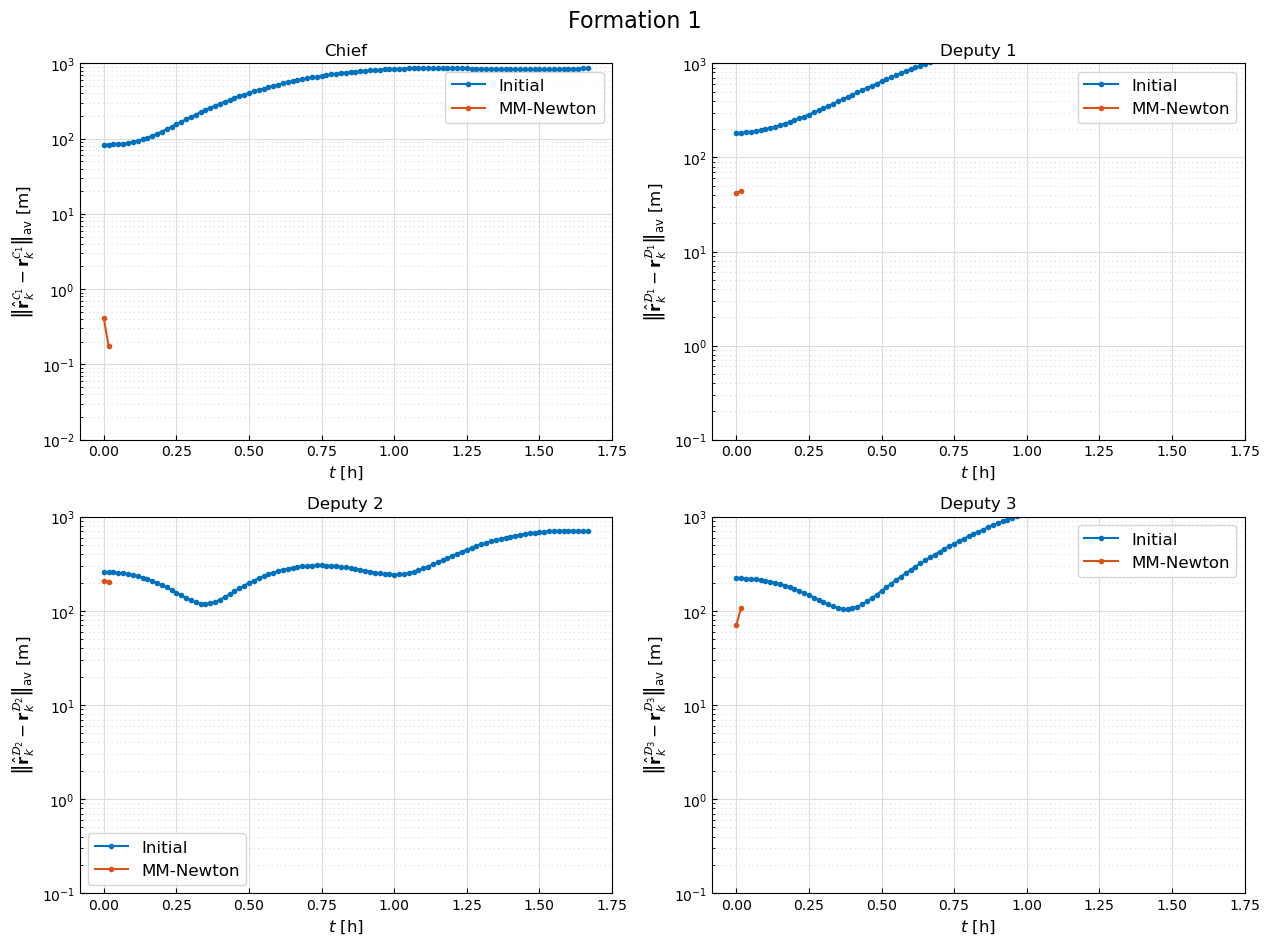

In [14]:
dev_chief = errors_chief_mm
dev_deputy1 = errors_deputy1_mm
dev_deputy2 = errors_deputy2_mm
dev_deputy3 = errors_deputy3_mm

# MATLAB default color cycle
matlab_default_colors = [
    [0, 0.4470, 0.7410],  # blue
    [0.8500, 0.3250, 0.0980],  # orange
    [0.9290, 0.6940, 0.1250],  # yellow
    [0.4940, 0.1840, 0.5560],  # purple
    [0.4660, 0.6740, 0.1880],  # green
    [0.3010, 0.7450, 0.9330],  # light blue
    [0.6350, 0.0780, 0.1840],  # red
]
# Set the color cycle in Matplotlib to match MATLAB's default
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=matlab_default_colors)

time = np.arange(0, T) / dt
algorithm = "MM-Newton"

# Plot positions based on screen size
fig_width = 2 * 6.4  # in inchesa
fig_height = 2 * 4.8  # in inches

# Create a 2 by 2 figure
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# Plot 1: Chief
axs[0, 0].plot(time, dev_chief_initial, ".-", label="Initial")
axs[0, 0].plot(time[:K - W + 1], dev_chief, ".-", label=algorithm)
axs[0, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 0].grid(True, which="both")
axs[0, 0].set_yscale("log")
axs[0, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{C}_1} - \\mathbf{r}_k^{\\mathcal{C}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[0, 0].set_ylim([1e-2, 1e3])
axs[0, 0].tick_params(axis="both", which="both", direction="in")
axs[0, 0].legend(fontsize=12)
axs[0, 0].set_title("Chief")

# Plot 2: Deputy 1
axs[0, 1].plot(time, dev_deputy1_initial, ".-", label="Initial")
axs[0, 1].plot(time[:K - W + 1], dev_deputy1, ".-", label=algorithm)
axs[0, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 1].grid(True, which="both")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_1} - \\mathbf{r}_k^{\\mathcal{D}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[0, 1].set_ylim([1e-1, 1e3])
axs[0, 1].tick_params(axis="both", which="both", direction="in")
axs[0, 1].legend(fontsize=12)
axs[0, 1].set_title("Deputy 1")

# Plot 3: Deputy 2
axs[1, 0].plot(time, dev_deputy2_initial, ".-", label="Initial")
axs[1, 0].plot(time[:K - W + 1], dev_deputy2, ".-", label=algorithm)
axs[1, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 0].grid(True, which="both")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_2} - \\mathbf{r}_k^{\\mathcal{D}_2}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[1, 0].set_ylim([1e-1, 1e3])
axs[1, 0].tick_params(axis="both", which="both", direction="in")
axs[1, 0].legend(fontsize=12)
axs[1, 0].set_title("Deputy 2")

# Plot 4: Deputy 3
axs[1, 1].plot(time, dev_deputy3_initial, ".-", label="Initial")
axs[1, 1].plot(time[:K - W + 1], dev_deputy3, ".-", label=algorithm)
axs[1, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 1].grid(True, which="both")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_3} - \\mathbf{r}_k^{\\mathcal{D}_3}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[1, 1].set_ylim([1e-1, 1e3])
axs[1, 1].tick_params(axis="both", which="both", direction="in")
axs[1, 1].legend(fontsize=12)
axs[1, 1].set_title("Deputy 3")

fig.suptitle(f"Formation {formation}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()